## Instalação e importação de bibliotecas

In [2]:
!pip install geopy
!pip install folium
!pip install pypl
!pip install k-means-constrained

     -------------------------------------- 119.8/119.8 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 40.3/40.3 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 102.3/102.3 kB 1.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from k_means_constrained import KMeansConstrained
from math import radians
from scipy.stats import gmean
from geopy.geocoders import Nominatim
import folium

##  Leitura dos arquivos

In [2]:
estab = pd.read_csv('tbl_estabelecimentos.csv', low_memory=False) #Potenciais clientes
coord = pd.read_excel('tbl_coordenadas.xlsx')                     #Coordenadas pAra associação
metr = pd.read_csv('tbl_metricas_ltv.csv')                        #CLientes atuais

## Tratamento dos dados

In [3]:
#Se houver dados duplicados de cnpj, vamos manter o último
estab.drop_duplicates(['cd_cnpj_anonimizado'], keep='last')

,cd_cnpj_anonimizado,cd_matriz_filial,st_cep,st_ramo,vl_potencial_faturamento_anual
0,7330555,1,20943000,Eletrodomesticos,77170
1,12772816,1,65700000,Mercados,259198
2,1385533,1,01135010,Estetica,8497
3,4674685,1,85856410,Vestimentas,77170
4,3296463,1,58750000,Construcao,17812
...,...,...,...,...,...
8374574,1219760,1,86081390,Mercados,133446
8374575,12907584,1,78120418,Escolas,8
8374576,7014686,1,17063060,Mercados,17812
8374577,6621703,1,80610260,Automoveis,77170


In [4]:
#Removendo linhas com faturamento igual a zero, pois não há dados suficientes para analisá-las
estab = estab.dropna(subset=['vl_potencial_faturamento_anual'])
estab = estab.drop(estab[estab.vl_potencial_faturamento_anual == 0].index)
estab = estab.dropna(subset=['st_cep'])  #Removendo linhas com cep vazio, pois não há como mapeá-las

#Inserindo "Outros" nos ramos vazios
estab['st_ramo'].fillna("Outros", inplace=True)

In [5]:
#Limpando a base de Métricas
metr = metr.dropna(axis=0, subset=['vl_tempo_vida_meses'])

In [6]:
"""
Objetivo é cruzar tabelas e encontrar latitude, longitude e UF de cada registro 
da tabela estabelecimentos
"""

estab['st_cep'] = estab['st_cep'].astype(str)
estab.st_cep = estab.st_cep.str[0:5]

estab['st_cep'] = estab['st_cep'].astype(int)

#Intersecção entre tabelas coord e estab
df = pd.merge(coord, estab, how='inner', left_on='cd_cep5', right_on='st_cep')
estab = df.drop(columns=['cd_cep5', 'st_bairro', 'st_municipio'])  #Excluindo colunas desnecessárias

In [7]:
#Funções para tratamento da base já limpa
#Enquadrando faturamentos dentro das faixas da base métricas

def faixa_fat(x):
    """
    Objetivo é enquadrar os valores de faturamento da base de estabelecimentos para as faixas presentes na base de métricas
    """
    if x<0:
        return 'fora do intervalo'
    if x<40*10**3: 
        return '<40k'
    elif x<75*10**3:
        return '40k a 75k'
    elif x<125*10**3:    
        return '75k a 125k'
    elif x<200*10**3:    
        return '125k a 200k'
    elif x<400*10**3:    
        return '200k a 400k'
    elif x<1*10**6:    
        return '400k a 1M'
    elif x<10*10**6:    
        return '1M a 10M'
    elif x<40*10**6:    
        return '10M a 40M'
    else:
        return '>40M'
    
#Função que calcula LTV
def LTV(fat,tr,tvm):
    """
    Objetivo é calcular o LTV com base no faturamento, take rate e tempo médio de vida dos clientes.
    """
    return (fat*tr)*(tvm/12)

In [8]:
#Coloca a faixa de faturamento no dataframe
estab['faixa_fat'] = estab.apply(lambda row: faixa_fat(row['vl_potencial_faturamento_anual']), axis=1)

In [9]:
#Cria chave pra encontrar a junção das features no dataframe de estabelecimentos
estab['chave'] = estab['st_uf'].map(str) + '_' + estab['faixa_fat'].map(str)+'_'+estab['st_ramo'].map(str)

#Cria chave pra encontrar a junção das features no dataframe de métricas
metr['chave'] = metr['st_uf'].map(str) + '_' + metr['st_faixa_faturamento_anual'].map(str)+'_'+metr['st_ramo'].map(str)
metr = metr.rename(columns={'st_uf':'st_uf_metr'})

In [10]:
#Passa take rate e tempo de vida médio, fazendo merge
df = pd.merge(estab, metr, how='inner', on='chave')
df = df.drop(columns=['st_uf_metr', 'chave', 'st_faixa_faturamento_anual',
                      'st_ramo_y', 'faixa_fat', 'st_cep', 'cd_matriz_filial'])

In [11]:
#Aplicação da função LTV
df['LTV'] = df.apply(lambda row: LTV(row['vl_potencial_faturamento_anual'], row['vl_take_rate'], row['vl_tempo_vida_meses']),
                     axis=1)

Existe uma amplitude grande entre os valores min e max de faturamento e LTV, mas nenhum deles se mostrou irreal. Dessa forma, não há necessidade de tratar outliers da base. Pelo fato de muitos estabelecimento terem LTV baixo, a média de LTV total realmente é muito menor que alguns LTVs específicos, porém, isso não os torna irreais ou inutilizáveis.

In [12]:
#Comprimindo a tabela para análise somente de atributos relevantes
mapeamento = df[['vl_latitude', 'vl_longitude', 'LTV', 'st_uf', 'cd_cnpj_anonimizado']]

## Análise inicial dos dados da base limpa

In [13]:
#Cálculo da quantidade de LTV disponível no Brasil todo
mapeamento.LTV.sum()

17171797734.028378

In [14]:
#Análise da soma de LTV disponível por estado
print(mapeamento.groupby(['st_uf']).LTV.sum().sort_values())

st_uf
RR    4.090016e+07
AP    5.157074e+07
AC    5.549901e+07
SE    1.480425e+08
TO    1.579780e+08
RO    1.588050e+08
AL    2.251160e+08
PI    2.492831e+08
PB    2.551701e+08
AM    2.743977e+08
RN    2.951897e+08
MS    2.980369e+08
MA    3.390829e+08
DF    3.999145e+08
MT    4.130316e+08
ES    4.433514e+08
PA    4.655550e+08
CE    6.059564e+08
PE    6.148045e+08
GO    6.608369e+08
RS    8.624839e+08
SC    8.701796e+08
BA    1.099742e+09
RJ    1.317949e+09
MG    1.370504e+09
PR    1.398895e+09
SP    4.099522e+09
Name: LTV, dtype: float64


In [15]:
#Análise da quantidade de estabelecimentos (registros) por estado
print(mapeamento.groupby(['st_uf']).LTV.count().sort_values())

st_uf
RR      13092
AP      13829
AC      14883
SE      45438
TO      45894
RO      48738
PI      63744
AL      71767
AM      75480
PB      85486
RN      90026
MS     104666
MA     105507
DF     116507
MT     123130
PA     157077
ES     158455
PE     199489
GO     199849
CE     208469
SC     319780
BA     328606
RS     416122
PR     465507
RJ     630862
MG     701278
SP    1909757
Name: LTV, dtype: int64


Focaremos nossas análises estado a estado. Dessa forma, como só temos 20 hubs disponíveis para alocação e existem 26 estados mais o DF para possíveis alocações, inicialmente não aprofundaremos nossas análises nos 6 estados que, ao mesmo tempo, possuem as menores somas de LTV e de estabelecimentos. Contudo, caso seja matematicamente possível alocar um hub de maior LTV após analisarmos as possibilidades, poderemos aprofundar nossas análises nesses estados. 

In [16]:
#Criando um dataframe para análise dos estados maiores e um dicionário com as somas de LTV e estabs
tab = pd.DataFrame()
ltv_uf = mapeamento.groupby(['st_uf']).LTV.sum().sort_values().to_dict()
estab_uf = mapeamento.groupby(['st_uf']).LTV.count().sort_values().to_dict()

In [17]:
tab['uf'] = mapeamento['st_uf'].unique()
tab['estab_uf'] = tab.apply(lambda row: estab_uf[row['uf']],axis=1)
tab['ltv_sum'] = tab.apply(lambda row: ltv_uf[row['uf']],axis=1)

In [18]:
estados_bottom6 = ['RR','AP','AC','SE','TO','RO']
tab_top = tab[~tab['uf'].isin(estados_bottom6)]

C:\Users\te-te\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\te-te\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\te-te\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\te-te\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\te-te\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be r

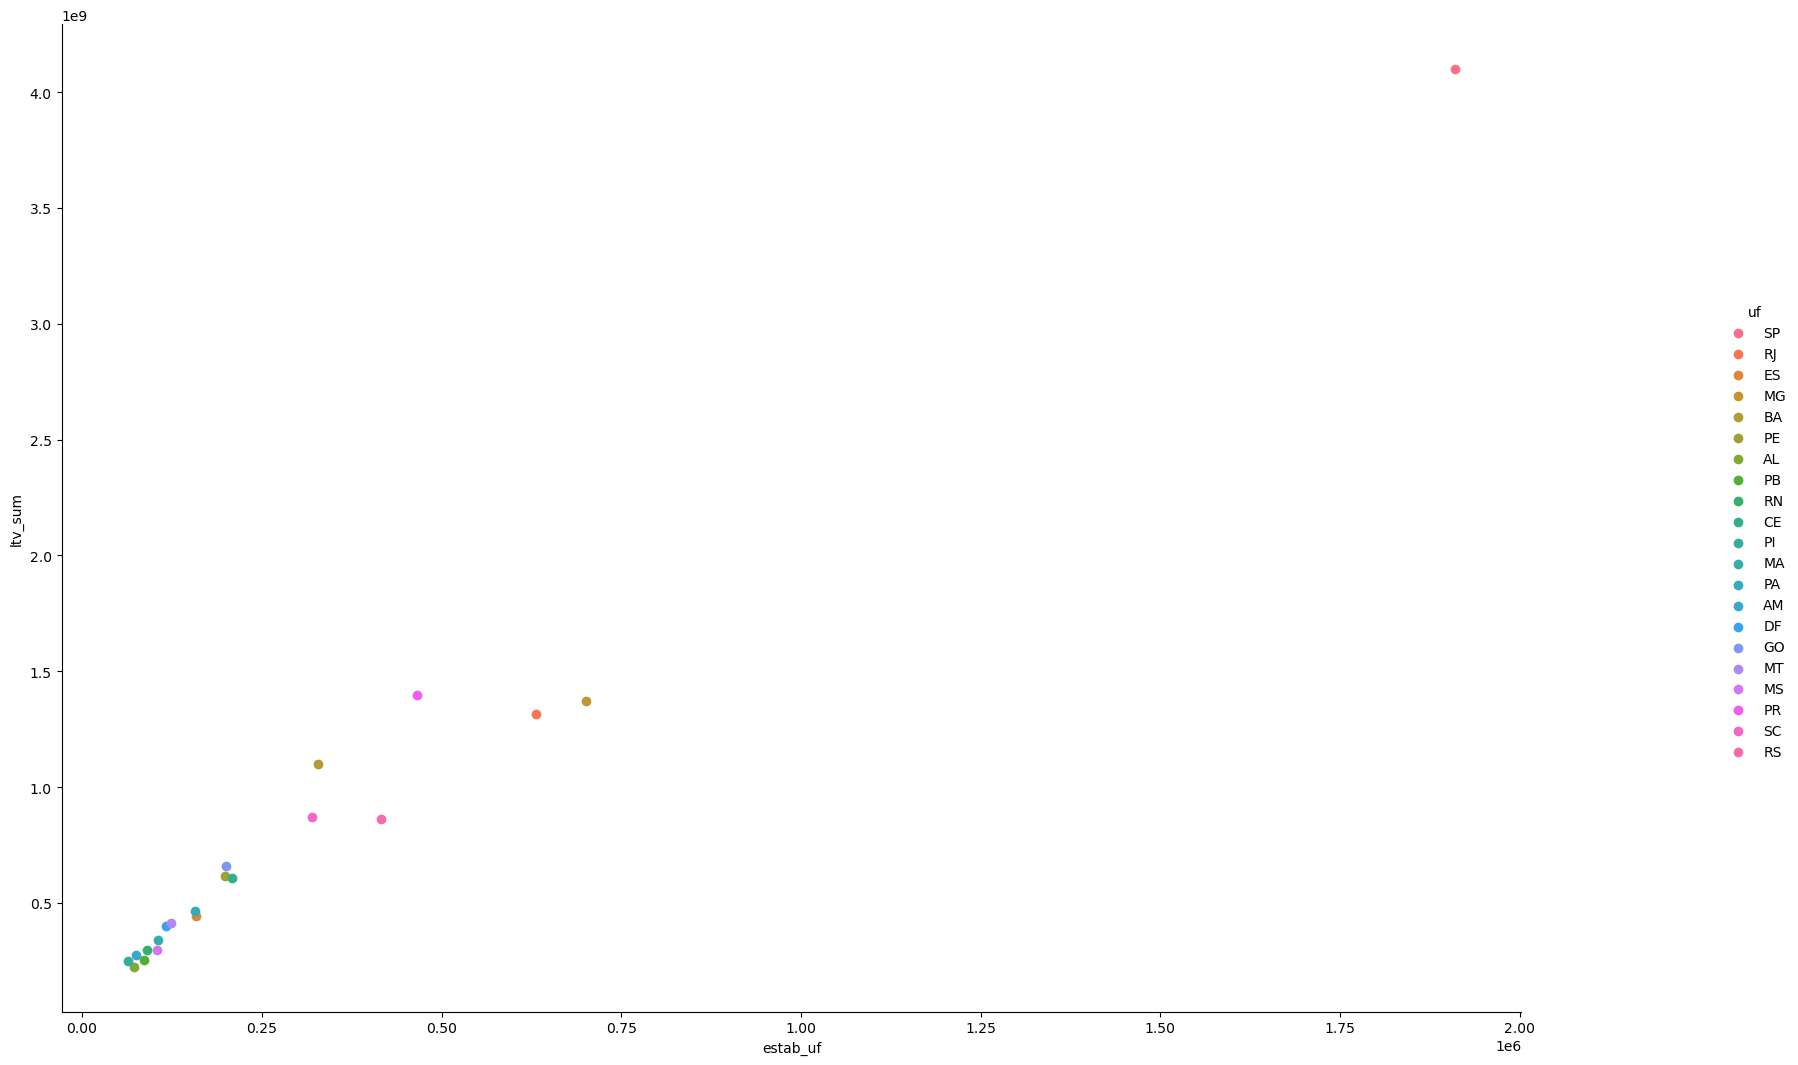

In [19]:
#Gráfico de soma de LTV por quantidade de estabelecimentos, estado a estado, dentro dos 21 maiores
a = sns.FacetGrid(tab_top, hue="uf", height=5) \
   .map(plt.scatter, "estab_uf", "ltv_sum") \
   .add_legend()
a.figure.set_size_inches(20,12)
plt.show()

A partir do gráfico acima, podemos perceber alguns grupos de estados que, correlacionando quantidade de estabelecimentos e valor total de LTV, se destacam dos outros. SP possui um destaque único nos dois fatores e, por isso, poderá necessitar, inclusive, de uma análise especial pelo número alto de estabelecimentos. Outros 5 estados mostram um potencial de agregar hubs do tipo A pelas suas alatas perfomances nas duas variáveis, são eles: RJ, MG, PR, BA, SC e RS. Outros três estados possuem LTVs não tão altos, mas por possuírem menos estabelcimentos, poderão representar boas alternativas de hubs, são eles: GO, PE e CE. Muitos dos outros estados possuem menos de 200 mil estabelecimentos, o que os coloca em desvantagem para receberem hubs do tipo A, mas podem ainda ser viáveis para outros hubs. Nossa lógica de alocação será decrescente, isto é, se baseará em analisar os melhores hubs do tipo A seguidos pelos hubs tipo B e, por fim, os do tipo C. 

## Definição de funções auxiliares

In [20]:
def clusterizacao(UF, n_c, s_m, s_M):
    """
    Função que forma grupos a partir de dados semelhantes.
    O produto de size_min e n_clusters não pode exceder o número de amostras.
    O produto de size_max e n_clusters deve exceder o número de amostras.
    Retorna as classes e os centroides para análise.
    """   
    clf = KMeansConstrained(
        n_clusters = n_c, #Número de clusters para análise
        size_min = s_m,   #Tamanho mínimo de amostras em um cluster
        size_max = s_M,   #Tamanho máximo de amostras em um cluster
        max_iter = 100,   #Máximo de iterações
        random_state = 0
    )
    clf.fit_predict(UF)
    return clf.labels_, clf.cluster_centers_

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calcular a distância do grande círculo entre dois pontos na terra 
    (especificado em graus decimais). Todos os argumentos devem ter o mesmo comprimento. 
    Retorno em quilômetros (km)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def veri_centroid(df, lat_c, long_c, tam_hub):
    """
    Recebe um dataframe e cria uma coluna de distância,
    que mede a distância do registro em relação a uma coordenada também passada,
    referente ao centróide de um cluster.
    Retorna o dataframe atualizado
    """
    df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)
    df = df[(df['dist'] <= 150)]
    df = df.sort_values(by='LTV', ascending=False)
    df = df.iloc[0:tam_hub, :]
    return df

def dropar_duplicatas(df_geral, df_especifico):
    """
    Recebe 2 dataframes e exclui registros iguais.
    Retorna o dataframe mais amplo sem as duplicatas.
    """
    return df_geral[~df_geral['cd_cnpj_anonimizado'].isin(df_especifico['cd_cnpj_anonimizado'])]

## Definição da função principal de clusterização

In [21]:
def clusterizacao_replicavel(unid_fed, n_clusters, s_min, s_max, capacidade_hub):
    """
    Recebe: sigla da unidade federativa como string, número de clusters desejado,
            tamanhos mínimo e máximo dos clusters e capacidade do hub.
    Retorna em formato de lista: dataframe dos estabelecimentos atendidos pelo hub,
            LTV total abrangido pelo hub e coordenadas do centróide (latitude e longitude, respectivamente).
    """
    #Filtrando estabelecimentos da unidade federaiva desejada
    X = mapeamento[mapeamento['st_uf'] == unid_fed]
    X_array = np.array(X.iloc[:, 0:3])
    #Chamada da função clusterizacao
    label, centroid = clusterizacao(X_array, n_clusters, s_min, s_max)
    #Adiciona ao dataframe uma coluna com a classe atribuída a cada registro
    X['Classe'] = label
    #Agrupa os registros conforme suas classes e ordena-as pelo LTV
    df = X.groupby(['Classe']).LTV.sum().sort_values()
    #Seleciona a classe com maior soma de LTV
    melhor_cluster = df.index[-1]
    #Cria uma coluna de distância no dataframe e aplica a função haversine_np a ela
    X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
    #Filtra os registros dentro do raio de alcance do hub (150km)
    df = X[(X['dist'] <= 150)]
    #Com a função veri_centroid, filtra os registros, considerando a capacidade do hub, e seleciona os maiores LTVs
    X = veri_centroid(X, centroid[melhor_cluster][0], centroid[melhor_cluster][1], capacidade_hub)
    LTV_hub = X.LTV.sum()
    print('Aproximadamente '+str(round((LTV_hub / mapeamento[mapeamento['st_uf'] == unid_fed].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')
    return [X, LTV_hub, centroid[melhor_cluster][0], centroid[melhor_cluster][1]]

In [22]:
RJ = clusterizacao_replicavel('RJ', 4, 157000, 200000, 200000)
df_RJ = RJ[0]
df_RJ.Classe = 'A'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 77.41% do LTV estadual


In [23]:
SC = clusterizacao_replicavel('SC', 3, 105500, 120000, 200000)
df_SC = SC[0]
df_SC.Classe = 'A'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 70.49% do LTV estadual


In [24]:
PE = clusterizacao_replicavel('PE', 3, 66000, 80000, 120000)
df_PE = PE[0]
df_PE.Classe = 'B'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 82.57% do LTV estadual


In [25]:
GO = clusterizacao_replicavel('GO', 3, 66565, 80000, 120000)
df_GO = GO[0]
df_GO.Classe = 'B'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 72.95% do LTV estadual


In [26]:
RS = clusterizacao_replicavel('RS', 3, 138000, 200000, 120000)
df_RS = RS[0]
df_RS.Classe = 'B'

C:\Users\te-te\anaconda3\lib\site-packages\k_means_constrained\k_means_constrained_.py:464: RuntimeWarning: invalid value encountered in cast
  costs = np.around(costs * 1000, 0).astype('int32')  # Times by 1000 to give extra precision
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda r

Aproximadamente 56.23% do LTV estadual


In [27]:
MG = clusterizacao_replicavel('MG', 4, 175000, 200000, 120000)
df_MG = MG[0]
df_MG.Classe = 'B'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 33.63% do LTV estadual


In [28]:
CE = clusterizacao_replicavel('CE', 3, 69000, 80000, 80000)
df_CE = CE[0]
df_CE.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 63.84% do LTV estadual


In [29]:
DF = clusterizacao_replicavel('DF', 2, 58000, 60000, 80000)
df_DF = DF[0]
df_DF.Classe = 'C'

C:\Users\te-te\anaconda3\lib\site-packages\k_means_constrained\k_means_constrained_.py:464: RuntimeWarning: invalid value encountered in cast
  costs = np.around(costs * 1000, 0).astype('int32')  # Times by 1000 to give extra precision
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda r

Aproximadamente 96.15% do LTV estadual


In [30]:
ES = clusterizacao_replicavel('ES', 2, 76565, 80000, 80000)
df_ES = ES[0]
df_ES.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 82.74% do LTV estadual


In [31]:
MS = clusterizacao_replicavel('MS', 2, 52000, 54000, 80000)
df_MS = MS[0]
df_MS.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 58.03% do LTV estadual


In [32]:
RN = clusterizacao_replicavel('RN', 2, 44000, 48000, 80000)
df_RN = RN[0]
df_RN.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 81.72% do LTV estadual


In [33]:
AM = clusterizacao_replicavel('AM', 2, 37500, 70000, 80000)
df_AM = AM[0]
df_AM.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 77.19% do LTV estadual


In [34]:
PB = clusterizacao_replicavel('PB', 3, 28000, 80000, 80000)
df_PB = PB[0]
df_PB.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 81.71% do LTV estadual


In [35]:
AL = clusterizacao_replicavel('AL', 2, 35000, 71767, 80000)
df_AL = AL[0]
df_AL.Classe = 'C'

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Classe'] = label
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\2853382662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist'] = X.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'], centroid[melhor_cluster][1], centroid[melhor_cluster][0]), axis=1)
C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying 

Aproximadamente 96.1% do LTV estadual


## Função secundária para alocação: Gmean

Essa função foi utilizada para contornar problemas que tivemos ao longo do caminho. Os estados PR e BA não mostraram bons resultados de alocação de hubs dos tipos A e B com o uso do kmeans. Sendo assim, buscamos outra ferramenta que nos devolveria uma tendência central para o local de um hub, que levasse em conta não apenas as coordenadas dos estabelecimentos dos estados, mas também o LTV relacionado a cada um deles.

Dessa forma, encontramos a função Gmean, que calcula uma média geométrica ponderada das coordenadas dos estabelecimentos de um estado. O uso da média geométrica ao invés de outras médias foi devido a termos encontrado algumas referências interessantes que defendiam o uso de média geométrica para problemas de geolocalização. O peso dado a cada coordenada foi o LTV à quarta de cada estabelecimento. A decisão de utilizar a quarta potência ao LTV foi de uma análise empírica do desempenho do Gmean com potências de LTV variando de 1 a 10 e, à quarta, os resultados foram potencializados. Além disso, o estado SP também foi analisado com o Gmean devido à dificuldade computacional de clusterização com quase dois milhões de estabelecimentos. Assim, recolhemos os dados de todos os estabelecimentos distantes de no máximo 150 km da coordenada obtida. Após isso, foram feitas as escolhas de qual tipo de hub seria alocado em torno deste ponto.

# Usando o Gmean pra BA, PR e SP

## Bahia

In [36]:
df_BA = mapeamento[mapeamento['st_uf'] == 'BA']
lat_BA = gmean((-1)*df_BA['vl_latitude'], weights = (df_BA['LTV'])**4)
long_BA =  gmean((-1)*df_BA['vl_longitude'], weights = (df_BA['LTV'])**4)
df_BA['dist']=df_BA.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_BA, (-1)*lat_BA), axis = 1)

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\4275440123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BA['dist']=df_BA.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_BA, (-1)*lat_BA), axis = 1)


In [37]:
#definição de hub de tipo B
df_BA = veri_centroid(df_BA, (-1)*lat_BA, (-1)*long_BA, 120000)
print(df_BA)

         vl_latitude  vl_longitude            LTV st_uf  cd_cnpj_anonimizado  \
3728913   -12.783941    -38.411519  562093.442169    BA                79904   
3728914   -12.783941    -38.411519  497118.750062    BA              1264199   
3713602   -12.935200    -38.493200  423918.125317    BA              3707248   
3728758   -12.982800    -38.512900  367949.363253    BA               249792   
3728761   -12.914500    -38.356200  367949.363253    BA               249798   
...              ...           ...            ...   ...                  ...   
3612367   -12.887500    -38.473000     466.722205    BA              8005736   
3612369   -12.896200    -38.479700     466.722205    BA              4251396   
3612421   -12.868800    -38.474300     466.722205    BA              8801826   
3612422   -12.868800    -38.474300     466.722205    BA             12907883   
3612425   -12.868800    -38.474300     466.722205    BA              9069882   

               dist  
3728913  132.1710

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)


In [38]:
df_BA['Classe'] = 'B'
df_BA = df_BA[['vl_latitude', 'vl_longitude', 'LTV','st_uf','cd_cnpj_anonimizado','Classe','dist']]

In [39]:
#Printando a porcentagem de LTV abragida
print('Aproximadamente '+str(round((df_BA.LTV.sum() / mapeamento[mapeamento['st_uf'] == 'BA'].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')

Aproximadamente 41.4% do LTV estadual


In [40]:
#Latitude e longitude do hub da bahia
print((-1)*lat_BA)
print((-1)*long_BA)

-11.69865928099385
-38.909482290026126


# Paraná

In [41]:
#Instalando um hub do tipo A
df_PR = mapeamento[mapeamento['st_uf'] == 'PR']
lat_PR_1 = gmean((-1)*df_PR['vl_latitude'], weights = (df_PR['LTV'])**4)
long_PR_1 =  gmean((-1)*df_PR['vl_longitude'], weights = (df_PR['LTV'])**4)
df_PR['dist']=df_PR.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_PR_1, (-1)*lat_PR_1), axis = 1)

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\3016972813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PR['dist']=df_PR.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_PR_1, (-1)*lat_PR_1), axis = 1)


In [42]:
#definição de hub do tipo A
df_PR = veri_centroid(df_PR, (-1)*lat_PR_1, (-1)*long_PR_1, 200000)
print(df_PR)

         vl_latitude  vl_longitude           LTV st_uf  cd_cnpj_anonimizado  \
5977508     -25.4765      -49.2464  1.603459e+06    PR             13827564   
5977387     -25.3934      -49.2781  6.222138e+05    PR              9678391   
5977386     -25.4465      -49.2759  6.222138e+05    PR              9678386   
5977385     -25.4435      -49.2637  6.222138e+05    PR              9678389   
5977509     -25.5177      -48.5091  5.739981e+05    PR                28847   
...              ...           ...           ...   ...                  ...   
5545302     -25.5202      -49.3038  3.708582e+02    PR              4953274   
5545300     -25.5202      -49.3038  3.708582e+02    PR             10009107   
5545299     -25.5202      -49.3038  3.708582e+02    PR             11148175   
5545297     -25.5202      -49.3038  3.708582e+02    PR              6826336   
5545296     -25.5202      -49.3038  3.708582e+02    PR              8036988   

               dist  
5977508   56.912172  
5977387

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)


In [43]:
df_PR['Classe'] = 'A'
df_PR = df_PR[['vl_latitude', 'vl_longitude', 'LTV','st_uf','cd_cnpj_anonimizado','Classe','dist']]

In [44]:
#Printando a porcentagem de LTV abragida
print('Aproximadamente '+str(round((df_PR.LTV.sum() / mapeamento[mapeamento['st_uf'] == 'PR'].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')

Aproximadamente 45.18% do LTV estadual


In [45]:
#Latitude e longitude do hub do tipo A do PR
print((-1)*lat_PR_1)
print((-1)*long_PR_1)

-25.08071289091572
-49.60585248455869


In [46]:
#Com o que sobrou de estabelecimentos, instalar um hub do tipo C no PR
#Encontrando o que sobrou dos estabelecimentos:
select_PR = df_PR['cd_cnpj_anonimizado']
df_PR_novo = mapeamento[mapeamento['st_uf'] == 'PR']
sobras_PR = df_PR_novo[~df_PR_novo['cd_cnpj_anonimizado'].isin(select_PR)]
print(sobras_PR)

         vl_latitude  vl_longitude            LTV st_uf  cd_cnpj_anonimizado
5512034   -25.434600    -49.270200     206.264340    PR             11594573
5512035   -25.434600    -49.270200     206.264340    PR              6612251
5512046   -25.434600    -49.270200      11.093657    PR             11301253
5512058   -25.429400    -49.272100     206.264340    PR             10591836
5512071   -25.429400    -49.272100       8.059287    PR              6142418
...              ...           ...            ...   ...                  ...
5977531   -24.558200    -54.059900    1640.641074    PR             13803240
5977532   -23.723403    -50.738480    1126.458221    PR               980343
5977533   -23.843888    -52.135129    1126.458221    PR             13794527
5977534   -24.321813    -52.529094    1306.498854    PR             13797736
5977535   -25.405900    -52.411700  225161.704687    PR              6348062

[265507 rows x 5 columns]


In [47]:
#Instalando um hub do tipo C
lat_PR_2 = gmean((-1)*sobras_PR['vl_latitude'], weights = (sobras_PR['LTV'])**4)
long_PR_2 =  gmean((-1)*sobras_PR['vl_longitude'], weights = (sobras_PR['LTV'])**4)
sobras_PR['dist']=sobras_PR.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_PR_2, (-1)*lat_PR_2), axis = 1)

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\4071475279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sobras_PR['dist']=sobras_PR.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_PR_2, (-1)*lat_PR_2), axis = 1)


In [48]:
#definição de hub do tipo C
sobras_PR = veri_centroid(sobras_PR, (-1)*lat_PR_2, (-1)*long_PR_2, 80000)
print(sobras_PR)

         vl_latitude  vl_longitude           LTV st_uf  cd_cnpj_anonimizado  \
5977388   -23.328500    -51.160400  1.120700e+06    PR               264952   
5975402   -23.407600    -51.960100  4.737326e+05    PR              3993610   
5977380   -23.003700    -51.194600  3.934734e+05    PR             13819369   
5975197   -23.422300    -51.938200  3.173550e+05    PR             13820382   
5975385   -23.051800    -50.226700  2.849997e+05    PR             13715478   
...              ...           ...           ...   ...                  ...   
5858104   -23.329700    -51.200300  1.306747e+03    PR              4565559   
5858105   -23.329700    -51.200300  1.306747e+03    PR              7416139   
5858134   -23.316200    -51.181800  1.306747e+03    PR              3637707   
5858136   -23.316200    -51.181800  1.306747e+03    PR              6167522   
5858610   -23.146427    -50.521071  1.306747e+03    PR              8444257   

               dist  
5977388   12.305363  
5975402

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)


In [49]:
sobras_PR['Classe'] = 'C'
sobras_PR = sobras_PR[['vl_latitude', 'vl_longitude', 'LTV','st_uf','cd_cnpj_anonimizado','Classe','dist']]

In [50]:
#Printando a porcentagem de LTV abragida
print('Aproximadamente '+str(round((sobras_PR.LTV.sum() / mapeamento[mapeamento['st_uf'] == 'PR'].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')

Aproximadamente 25.26% do LTV estadual


In [51]:
#Latitude e longitude do hub do tipo C do PR
print((-1)*lat_PR_2)
print((-1)*long_PR_2)

-23.394618888163787
-51.25716013774655


## São Paulo

In [52]:
#Primeiro hub do tipo A
df_SP = mapeamento[mapeamento['st_uf'] == 'SP']
lat_SP_1 = gmean((-1)*df_SP['vl_latitude'], weights = (df_SP['LTV'])**4)
long_SP_1 =  gmean((-1)*df_SP['vl_longitude'], weights = (df_SP['LTV'])**4)
df_SP['dist']=df_SP.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_SP_1, (-1)*lat_SP_1), axis = 1)


C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\234969168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SP['dist']=df_SP.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_SP_1, (-1)*lat_SP_1), axis = 1)


In [53]:
#definição de hub do tipo A
df_SP = veri_centroid(df_SP, (-1)*lat_SP_1, (-1)*long_SP_1, 200000)
print(df_SP)

         vl_latitude  vl_longitude           LTV st_uf  cd_cnpj_anonimizado  \
1909750   -23.982900    -48.876300  1.475125e+06    SP              2038189   
1909752   -22.727300    -47.651900  8.927738e+05    SP               135579   
1909135   -23.615302    -47.019648  7.743180e+05    SP              6567210   
1909133   -23.518900    -46.673500  6.386664e+05    SP              3895209   
1909134   -23.499200    -46.830900  4.515195e+05    SP             13674682   
...              ...           ...           ...   ...                  ...   
861138    -23.394020    -46.746770  2.556012e+03    SP              4347727   
861117    -23.397350    -46.707290  2.556012e+03    SP              6711562   
876007    -23.473400    -47.449000  2.556012e+03    SP              4048033   
854917    -23.468800    -46.581000  2.556012e+03    SP              9428485   
861091    -23.352280    -46.748590  2.556012e+03    SP              9339730   

               dist  
1909750   97.220206  
1909752

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)


In [54]:
df_SP['Classe'] = 'A'
df_SP = df_SP[['vl_latitude', 'vl_longitude', 'LTV','st_uf','cd_cnpj_anonimizado','Classe','dist']]

In [55]:
#Printando a porcentagem de LTV abragida
print('Aproximadamente '+str(round((df_SP.LTV.sum() / mapeamento[mapeamento['st_uf'] == 'SP'].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')

Aproximadamente 41.68% do LTV estadual


In [56]:
#latitude e longitude hub1 sp tipo A
print("lat = ", (-1)*lat_SP_1)
print("long = ", (-1)*long_SP_1)

lat =  -23.59370368236804
long =  -48.02001342448339


In [57]:
#Com o que sobrou de estabelecimentos, instalar um segundo hub do tipo A no SP
#Encontrando o que sobrou dos estabelecimentos:
select_SP_1 = df_SP['cd_cnpj_anonimizado']
df_SP_novo = mapeamento[mapeamento['st_uf'] == 'SP']
sobras_SP_1 = df_SP_novo[~df_SP_novo['cd_cnpj_anonimizado'].isin(select_SP_1)]
SOBRAS_SP_1_reserva = sobras_SP_1 #reserva para a instalação de um próximo hub
print(sobras_SP_1)

         vl_latitude  vl_longitude            LTV st_uf  cd_cnpj_anonimizado
1867        -23.6034      -46.5455    5637.199713    SP              3448265
1873        -23.6020      -46.5353    6525.855116    SP              4080766
1874        -23.6020      -46.5353    4225.376915    SP              2267180
1875        -23.6020      -46.5353    7983.827980    SP             13437447
1881        -23.5958      -46.5465    6525.855116    SP              5885561
...              ...           ...            ...   ...                  ...
1909745     -21.5650      -48.4687  404286.633861    SP             13669005
1909748     -23.4297      -46.4001  320846.471569    SP             13625598
1909753     -21.6059      -48.3635  371921.466907    SP              6554016
1909754     -21.6831      -49.7668  391046.107456    SP               308717
1909755     -20.8925      -51.3698  391046.107456    SP               308716

[1709757 rows x 5 columns]


In [58]:
#Segundo hub do tipo A
lat_SP_2 = gmean((-1)*sobras_SP_1['vl_latitude'], weights = (sobras_SP_1['LTV'])**4)
long_SP_2 =  gmean((-1)*sobras_SP_1['vl_longitude'], weights = (sobras_SP_1['LTV'])**4)
sobras_SP_1['dist']=sobras_SP_1.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_SP_2, (-1)*lat_SP_2), axis = 1)

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\24207277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sobras_SP_1['dist']=sobras_SP_1.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_SP_2, (-1)*lat_SP_2), axis = 1)


In [59]:
#definição de hub do tipo A
sobras_SP_1 = veri_centroid(sobras_SP_1, (-1)*lat_SP_2, (-1)*long_SP_2, 200000)
print(sobras_SP_1)

         vl_latitude  vl_longitude            LTV st_uf  cd_cnpj_anonimizado  \
1909137     -23.6440      -46.3100  768758.154291    SP             13747274   
1909674     -22.3541      -47.3836  589713.817603    SP             13602119   
1909739     -23.4211      -46.3716  497302.291578    SP             13657562   
1909676     -23.8040      -46.5101  414573.795892    SP             13656019   
1909136     -23.4773      -46.5222  383457.631368    SP              7627864   
...              ...           ...            ...   ...                  ...   
155959      -23.5707      -46.4082    1690.080180    SP              3860936   
148248      -23.6952      -46.6663    1690.080180    SP               128977   
156307      -23.4688      -46.3272    1690.080180    SP               946454   
156298      -23.4681      -46.3038    1690.080180    SP             12490631   
156290      -23.4896      -46.3009    1690.080180    SP             11658746   

               dist  
1909137  113.4393

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)


In [60]:
sobras_SP_1['Classe'] = 'A'
sobras_SP_1 = sobras_SP_1[['vl_latitude', 'vl_longitude', 'LTV','st_uf','cd_cnpj_anonimizado','Classe','dist']]

In [61]:
#Printando a porcentagem de LTV abragida
print('Aproximadamente '+str(round((sobras_SP_1.LTV.sum() / mapeamento[mapeamento['st_uf'] == 'SP'].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')

Aproximadamente 20.93% do LTV estadual


In [62]:
#latitude e longitude hub2 sp tipo A
print("lat = ", (-1)*lat_SP_2)
print("long = ", (-1)*long_SP_2)

lat =  -22.914005767184516
long =  -47.086826785393804


In [63]:
#Com o que sobrou de estabelecimentos, instalar um hub do tipo C no SP
#Encontrando o que sobrou dos estabelecimentos:
select_SP_2 = sobras_SP_1['cd_cnpj_anonimizado']
sobras_SP_2 = SOBRAS_SP_1_reserva[~SOBRAS_SP_1_reserva['cd_cnpj_anonimizado'].isin(select_SP_2)]
SOBRAS_SP_2_reserva = SOBRAS_SP_1_reserva[~SOBRAS_SP_1_reserva['cd_cnpj_anonimizado'].isin(select_SP_2)]

In [64]:
#latitude e longitude para um hub do tipo C
lat_SP_3 = gmean((-1)*sobras_SP_2['vl_latitude'], weights = (sobras_SP_2['LTV'])**4)
long_SP_3 =  gmean((-1)*sobras_SP_2['vl_longitude'], weights = (sobras_SP_2['LTV'])**4)
sobras_SP_2['dist']=sobras_SP_2.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_SP_3, (-1)*lat_SP_3), axis = 1)

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\3932271503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sobras_SP_2['dist']=sobras_SP_2.apply(lambda row: haversine_np(row['vl_longitude'],row['vl_latitude'], (-1)*long_SP_3, (-1)*lat_SP_3), axis = 1)


In [65]:
#definição de hub do tipo C
sobras_SP_2 = veri_centroid(sobras_SP_2, (-1)*lat_SP_3, (-1)*long_SP_3, 80000)
print(sobras_SP_2)

         vl_latitude  vl_longitude            LTV st_uf  cd_cnpj_anonimizado  \
1909138     -21.1671      -47.7973  497758.191719    SP               830413   
1909745     -21.5650      -48.4687  404286.633861    SP             13669005   
1909754     -21.6831      -49.7668  391046.107456    SP               308717   
1909753     -21.6059      -48.3635  371921.466907    SP              6554016   
1908471     -21.1163      -47.7909  333192.545493    SP             12793535   
...              ...           ...            ...   ...                  ...   
962030      -21.6059      -48.3635    1212.391733    SP               196209   
962032      -21.6059      -48.3635    1212.391733    SP              6617294   
957353      -22.5734      -47.4031    1212.391733    SP             12528313   
957352      -22.5734      -47.4031    1212.391733    SP             13099216   
962033      -21.6059      -48.3635    1212.391733    SP               861369   

               dist  
1909138  100.8161

C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1082795730.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df.apply(lambda row: haversine_np(row['vl_longitude'], row['vl_latitude'],  long_c, lat_c), axis=1)


In [66]:
sobras_SP_2['Classe'] = 'C'
sobras_SP_2 = sobras_SP_2[['vl_latitude', 'vl_longitude', 'LTV','st_uf','cd_cnpj_anonimizado','Classe','dist']]

In [67]:
#Printando a porcentagem de LTV abragida
print('Aproximadamente '+str(round((sobras_SP_2.LTV.sum() / mapeamento[mapeamento['st_uf'] == 'SP'].LTV.sum()) * 100, 2))+ '%'+' do LTV estadual')

Aproximadamente 7.86% do LTV estadual


In [68]:
#latitude e longitude hub do tipo C em sp
print("lat = ", (-1)*lat_SP_3)
print("long = ", (-1)*long_SP_3)

lat =  -21.82125080795366
long =  -48.47290356310254


## Concatenação dos dataframes dos hubs

In [69]:
alocados = pd.DataFrame()
frames = (alocados, df_PR, df_SP, sobras_SP_1, df_RJ, df_SC, df_PE, df_GO, df_RS, df_MG, df_BA, df_CE, df_DF, df_ES, sobras_PR, sobras_SP_2, df_RN, df_AL, df_AM, df_PB, df_MS)
alocados = pd.concat(frames)

In [70]:
print(mapeamento.head())

   vl_latitude  vl_longitude          LTV st_uf  cd_cnpj_anonimizado
0     -23.5506      -46.6343  9853.961949    SP               313746
1     -23.5506      -46.6343  4225.376915    SP              5800807
2     -23.5506      -46.6343  6271.998990    SP              1206608
3     -23.5476      -46.6362  4225.376915    SP              1130143
4     -23.5476      -46.6362  6341.275365    SP              6056402


# Análise dos hubs alocados

In [71]:
geolocator = Nominatim(user_agent="geoapiExercises")

mapeamento = pd.read_csv('base_final_estab.csv')


LTV_total = mapeamento.LTV.sum()
LTV_disponivel = mapeamento.LTV.nlargest(2400000).sum()

df = pd.merge(alocados, mapeamento,  how='inner', left_on='cd_cnpj_anonimizado', right_on='cd_cnpj_anonimizado')
df = df[['cd_cnpj_anonimizado','st_ramo_x', 'Classe', 'vl_potencial_faturamento_anual', 'LTV_y']]
    
df.rename(columns = {'LTV_y':'LTV'}, inplace = True)
print(df.head())

   cd_cnpj_anonimizado   st_ramo_x Classe  vl_potencial_faturamento_anual  \
0             13827564  Construcao      A                       120491780   
1              9678391  Variedades      A                        56611425   
2              9678386  Variedades      A                        56611425   
3              9678389  Variedades      A                        56611425   
4                28847  Construcao      A                        43133026   

            LTV  
0  1.603459e+06  
1  6.222138e+05  
2  6.222138e+05  
3  6.222138e+05  
4  5.739981e+05  


In [72]:
def localizacao(Latitude, Longitude):
    location = geolocator.reverse(Latitude+","+Longitude) 
    address = location.raw['address'] 
    print(f"O CEP é: {address['postcode']}")
    return address['postcode']

## Mapeamento dos Hubs

In [73]:
mapa = folium.Map(location = [-16, -43], zoom_start=3)

# A - Amarelo
# B - Verde
# C - Azul

#GO - B
folium.Circle(
    location=[-16.58297619, -49.18121983],
    radius = 150000,
    color='green',
    fill=True,
    fill_color ='#3186cc'    
).add_to(mapa)
folium.Circle(
    location=[-16.58297619, -49.18121983],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#PE - B
folium.Circle(

    location = [-8.19549872, -35.9720766],
    radius = 150000,
    color='green',
    fill=True,
    fill_color ='green'    
).add_to(mapa)
folium.Circle(

    location = [-8.19549872, -35.9720766],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)


#CE - C
folium.Circle(
    location=[-4.39093276, -39.0397883],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(

    location = [-4.39093276, -39.0397883],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#SC - A
folium.Circle(
    location=[-27.22200399, -49.71777823],
    radius = 150000,
    color='yellow',
    fill=True,
    fill_color ='yellow'    
).add_to(mapa)
folium.Circle(
    location = [-27.22200399, -49.71777823],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

    #RS - B
folium.Circle(
    location=[-29.50604948, -52.07953343],
    radius = 150000,
    color='green',
    fill=True,
    fill_color ='grenn'    
).add_to(mapa)
folium.Circle(
    location=[-29.50604948, -52.07953343],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#MG - B
folium.Circle(
    location=[-19.66359019, -44.56388694],
    radius = 150000,
    color='green',
    fill=True,
    fill_color ='grenn'    
).add_to(mapa)
folium.Circle(
    location=[-19.66359019, -44.56388694],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#RJ - A
folium.Circle(    
    location=[-22.70880731, -43.14189407],
    radius = 150000,
    color='yellow',
    fill=True,
    fill_color ='yellow'    
).add_to(mapa)
folium.Circle(    
    location=[-22.70880731, -43.14189407],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#BA - B
folium.Circle(  
    location=[-11.698, -38.909],
    radius = 150000,
    color='green',
    fill=True,
    fill_color ='grenn'    
).add_to(mapa)
folium.Circle(   
    location=[-11.698, -38.909],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#PR - A
folium.Circle(    
    location=[-25.080, -49.60],
    radius = 150000,
    color='yellow',
    fill=True,
    fill_color ='yellow'    
).add_to(mapa)
folium.Circle(    
    location=[-25.080, -49.60],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#SP - A1
folium.Circle(    
    location=[-23.593, -48.020],
    radius = 150000,
    color='yellow',
    fill=True,
    fill_color ='yellow'    
).add_to(mapa)
folium.Circle(    
    location=[-23.593, -48.020],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#SP - A2
folium.Circle(   
    location=[-22.914, -47.086],
    radius = 150000,
    color='yellow',
    fill=True,
    fill_color ='yellow'    
).add_to(mapa)
folium.Circle(   
    location=[-22.914, -47.086],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#SP - C3
folium.Circle(
    location=[-21.821, -48.472],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(
    location=[-21.821, -48.472],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#PR - C2
folium.Circle(    
    location=[-23.394, -51.257],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(    
    location=[-23.394, -51.257],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#DF - C
folium.Circle(   
    location=[-15.82795602, -47.97963765],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(   
    location=[-15.82795602, -47.97963765],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#ES - C
folium.Circle(   
    location=[-20.11332405, -40.52739593],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(   
    location=[-20.11332405, -40.52739593],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#MS - C
folium.Circle(   
    location=[-20.92488317, -54.44739041],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(   
    location=[-20.92488317, -54.44739041],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#PB - C
folium.Circle(   
    location=[-7.05613487, -35.99635752],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(   
    location=[-7.05613487, -35.99635752],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#RN - C
folium.Circle(    
    location=[-5.82623349, -36.01951999],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(    
    location=[-5.82623349, -36.01951999],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#AM - C
folium.Circle(   
    location=[-3.40980075, -60.7401640],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(   
    location=[-3.40980075, -60.7401640],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)

#AL - C
folium.Circle(    
    location=[-9.59723812, -36.14148849],
    radius = 150000,
    color='blue',
    fill=True,
    fill_color ='blue'    
).add_to(mapa)
folium.Circle(
    location=[-9.59723812, -36.14148849],
    radius = 1500,
    color='red',
    fill=True,
    fill_color ='red'    
).add_to(mapa)


mapa

# Análise descritiva dos hubs alocados
























































### *Quantidade de estabelecimentos por hubs

In [74]:
print(df.groupby(['Classe']).cd_cnpj_anonimizado.count())
print(df.cd_cnpj_anonimizado.count())

Classe
A    1000000
B     600000
C     738565
Name: cd_cnpj_anonimizado, dtype: int64
2338565


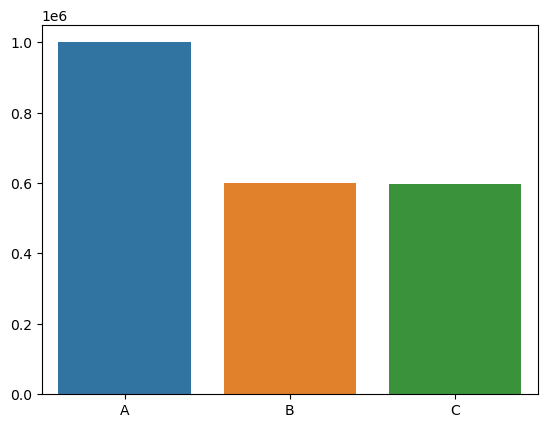

In [75]:
sns.barplot(y=[1000000, 600000, 597260], x=['A', 'B', 'C'])
plt.show()

## *Análise hub tipo A

In [76]:
df_A = df[df['Classe'] == 'A']
df_A.head()

,cd_cnpj_anonimizado,st_ramo_x,Classe,vl_potencial_faturamento_anual,LTV
0,13827564,Construcao,A,120491780,1.603459e+06
1,9678391,Variedades,A,56611425,6.222138e+05
2,9678386,Variedades,A,56611425,6.222138e+05
3,9678389,Variedades,A,56611425,6.222138e+05
4,28847,Construcao,A,43133026,5.739981e+05


In [77]:
df_A.describe()

,cd_cnpj_anonimizado,vl_potencial_faturamento_anual,LTV
count,1.000000e+06,1.000000e+06,1.000000e+06
mean,6.708860e+06,4.566137e+05,4.832324e+03
std,4.127987e+06,1.225044e+06,1.120894e+04
min,2.700000e+01,1.374200e+04,3.708582e+02
25%,3.100537e+06,1.334460e+05,1.626487e+03
50%,6.437163e+06,2.217660e+05,2.670451e+03
75%,1.033115e+07,4.631340e+05,5.093799e+03
max,1.395692e+07,2.136577e+08,1.810648e+06


### -Análise Ramos

In [78]:
print(df_A.groupby(['st_ramo_x']).Classe.count().sort_values(ascending=False))

st_ramo_x
Construcao          139113
Mercados            124605
Refeicao            113593
Vestimentas         112174
Variedades          104100
Automoveis           77825
Saude                76207
Eletrodomesticos     65482
Estetica             64118
Turismo              57170
Escolas              41770
Entreterimento       17648
Postos                6093
Cias_Aereas            102
Name: Classe, dtype: int64


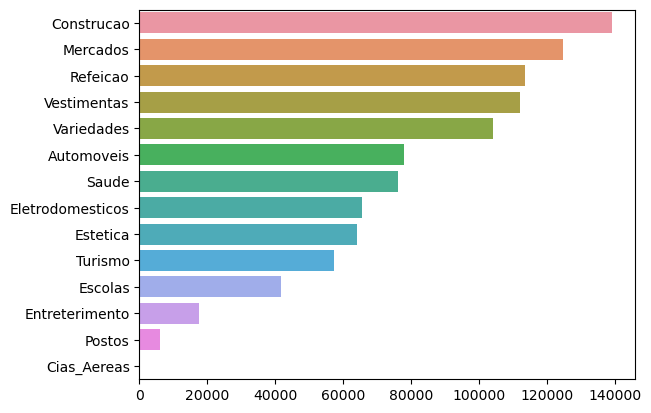

In [79]:
sns.barplot(data=df_A, x=df_A.st_ramo_x.value_counts().tolist(), y=df_A.st_ramo_x.value_counts().index)
plt.show()

### -Análise Faixa de TPV

In [80]:
df_A['Faixa_de_TPV'] = df_A.vl_potencial_faturamento_anual.apply(faixa_fat)

print(df_A.groupby(['Faixa_de_TPV']).Classe.count().sort_values(ascending=False))

Faixa_de_TPV
400k a 1M      274138
200k a 400k    238140
125k a 200k    195108
<40k           101594
75k a 125k      95486
1M a 10M        59023
40k a 75k       33873
10M a 40M        2585
>40M               53
Name: Classe, dtype: int64


C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\519517386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A['Faixa_de_TPV'] = df_A.vl_potencial_faturamento_anual.apply(faixa_fat)


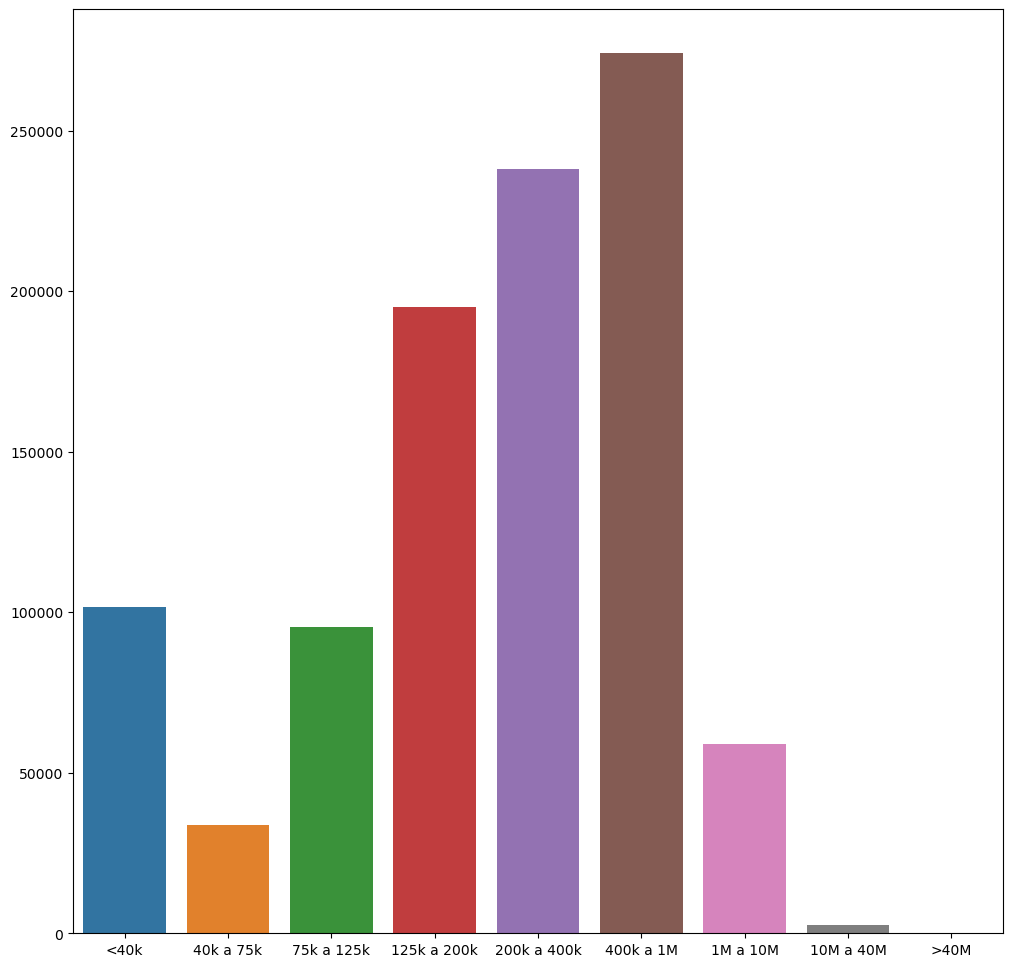

In [81]:
sns.barplot(data=df_A, y=df_A.Faixa_de_TPV.value_counts().tolist(), x=df_A.Faixa_de_TPV.value_counts().index, order = ['<40k', '40k a 75k', '75k a 125k', '125k a 200k', '200k a 400k', '400k a 1M', '1M a 10M', '10M a 40M', '>40M']).figure.set_size_inches(12,12)
plt.show()

### -Ramo x Faixa de TPV

In [82]:
print(df_A.groupby(['st_ramo_x']).vl_potencial_faturamento_anual.sum().sort_values(ascending=False))

st_ramo_x
Mercados            68982537326
Construcao          59046706728
Saude               55672863296
Variedades          41842108492
Automoveis          40615863958
Vestimentas         40373231985
Refeicao            40322415527
Turismo             29219655677
Eletrodomesticos    27756900631
Escolas             19723040609
Estetica            14663722867
Entreterimento       9504394195
Postos               8217884136
Cias_Aereas           672378242
Name: vl_potencial_faturamento_anual, dtype: int64


## *Análise hub tipo B

In [83]:
df_B = df[df['Classe'] == 'B']
df_B.head()

,cd_cnpj_anonimizado,st_ramo_x,Classe,vl_potencial_faturamento_anual,LTV
1000000,1407725,Mercados,B,206113514,2.096836e+06
1000001,1852886,Automoveis,B,108391900,1.165149e+06
1000002,10144378,Refeicao,B,32712150,4.055789e+05
1000003,13670458,Construcao,B,32476835,3.991564e+05
1000004,1639344,Variedades,B,37385005,3.924039e+05


In [84]:
df_B.describe()

,cd_cnpj_anonimizado,vl_potencial_faturamento_anual,LTV
count,6.000000e+05,6.000000e+05,6.000000e+05
mean,6.734999e+06,3.452588e+05,3.984815e+03
std,4.040600e+06,9.295942e+05,9.094469e+03
min,4.000000e+00,1.777600e+04,4.667222e+02
25%,3.197620e+06,7.717000e+04,1.348961e+03
50%,6.565248e+06,1.577910e+05,2.132885e+03
75%,1.027077e+07,3.847310e+05,4.260794e+03
max,1.395762e+07,2.061135e+08,2.096836e+06


### -Análise Ramos

In [85]:
print(df_B.groupby(['st_ramo_x']).Classe.count().sort_values(ascending=False))

st_ramo_x
Mercados            88216
Construcao          79698
Vestimentas         78697
Refeicao            61302
Variedades          58802
Saude               47056
Automoveis          44161
Eletrodomesticos    39367
Estetica            38134
Turismo             28179
Escolas             23421
Entreterimento       8839
Postos               4084
Cias_Aereas            44
Name: Classe, dtype: int64


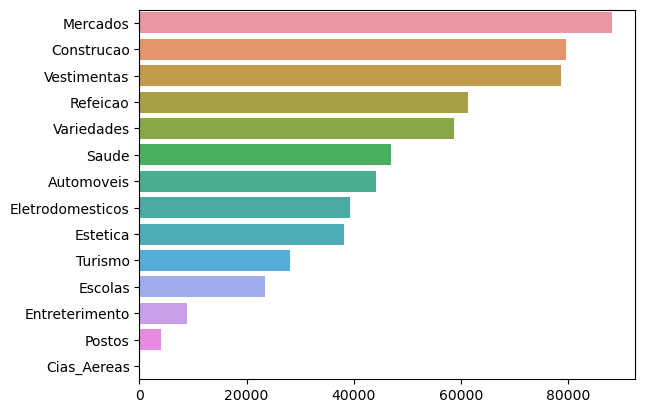

In [86]:
sns.barplot(data=df_B, x=df_B.st_ramo_x.value_counts().tolist(), y=df_B.st_ramo_x.value_counts().index)
plt.show()

### -Análise Faixa de TPV

In [87]:
df_B['Faixa_de_TPV'] = df_B.vl_potencial_faturamento_anual.apply(faixa_fat)

print(df_B.groupby(['Faixa_de_TPV']).Classe.count().sort_values(ascending=False))

Faixa_de_TPV
125k a 200k    147701
400k a 1M      125327
75k a 125k     124500
200k a 400k    120044
40k a 75k       32597
<40k            26288
1M a 10M        22815
10M a 40M         709
>40M               19
Name: Classe, dtype: int64


C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\791397034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_B['Faixa_de_TPV'] = df_B.vl_potencial_faturamento_anual.apply(faixa_fat)


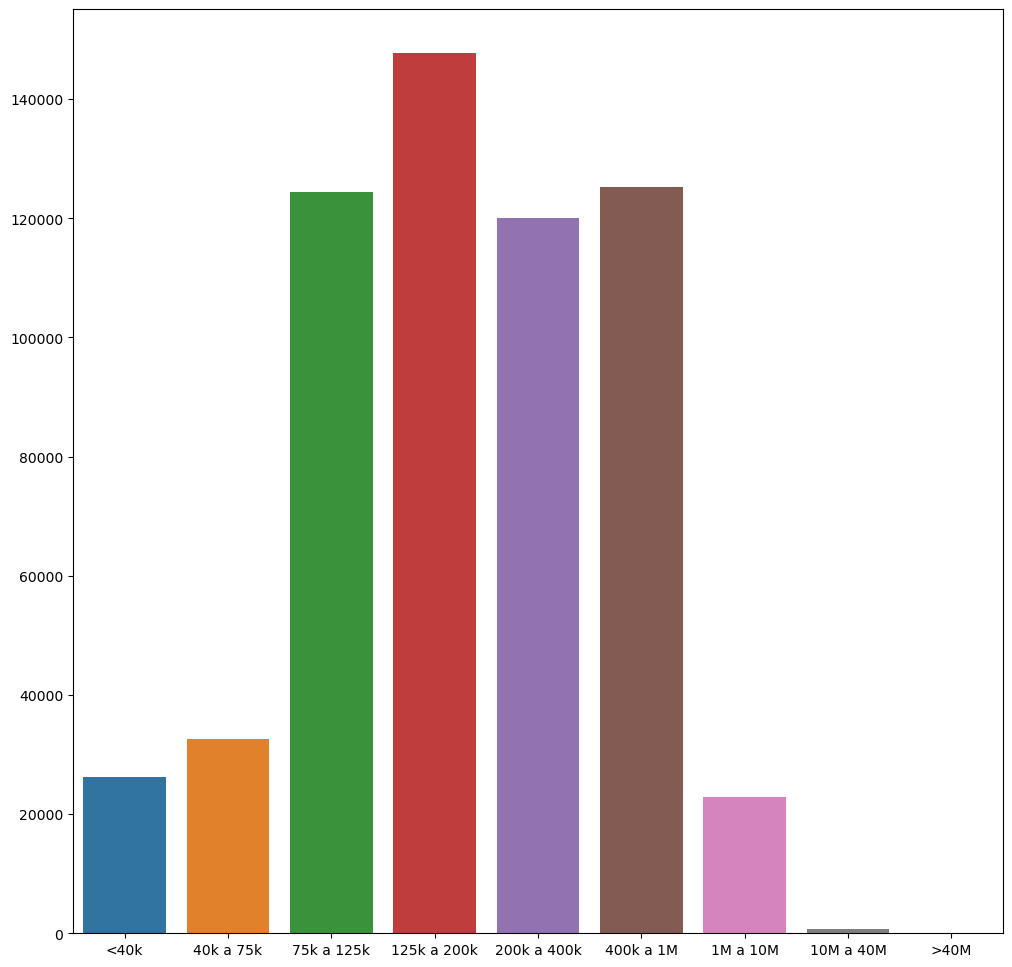

In [88]:
sns.barplot(data=df_B, y=df_B.Faixa_de_TPV.value_counts().tolist(), x=df_B.Faixa_de_TPV.value_counts().index, order = ['<40k', '40k a 75k', '75k a 125k', '125k a 200k', '200k a 400k', '400k a 1M', '1M a 10M', '10M a 40M', '>40M']).figure.set_size_inches(12,12)
plt.show()

### -Ramo x Faixa de TPV

In [89]:
print(df_B.groupby(['st_ramo_x']).vl_potencial_faturamento_anual.sum().sort_values(ascending=False))

st_ramo_x
Mercados            33870364861
Construcao          26619148041
Saude               24123295607
Vestimentas         20017718563
Variedades          19096827091
Automoveis          18758879348
Refeicao            15310360601
Eletrodomesticos    13440222891
Turismo             12223850455
Escolas              8413671899
Estetica             7185304340
Postos               4070092624
Entreterimento       3730210553
Cias_Aereas           295312768
Name: vl_potencial_faturamento_anual, dtype: int64


## *Análise hub tipo C

In [90]:
df_C = df[df['Classe'] == 'C']
df_C.head()

,cd_cnpj_anonimizado,st_ramo_x,Classe,vl_potencial_faturamento_anual,LTV
1600000,1568422,Construcao,C,104588270,1.519763e+06
1600001,6656267,Saude,C,63893699,6.008882e+05
1600002,6656266,Saude,C,63893699,6.008882e+05
1600003,1963559,Mercados,C,50563675,5.410872e+05
1600004,835716,Mercados,C,33215916,3.947280e+05


In [91]:
df_C.describe()

,cd_cnpj_anonimizado,vl_potencial_faturamento_anual,LTV
count,7.385650e+05,7.385650e+05,7.385650e+05
mean,6.860264e+06,3.068436e+05,3.878454e+03
std,3.962165e+06,8.946164e+05,9.723918e+03
min,3.600000e+01,1.000000e+00,1.875598e-02
25%,3.450270e+06,7.717000e+04,1.332549e+03
50%,6.786945e+06,1.334460e+05,2.085922e+03
75%,1.029530e+07,2.936830e+05,4.144631e+03
max,1.395697e+07,2.481446e+08,2.636729e+06


### -Análise Ramos

In [92]:
print(df_C.groupby(['st_ramo_x']).Classe.count().sort_values(ascending=False))

st_ramo_x
Mercados            107190
Construcao           94378
Vestimentas          87512
Variedades           77282
Refeicao             72166
Estetica             55824
Automoveis           55477
Saude                53937
Eletrodomesticos     50230
Turismo              38591
Escolas              30295
Entreterimento       11331
Postos                4293
Cias_Aereas             59
Name: Classe, dtype: int64


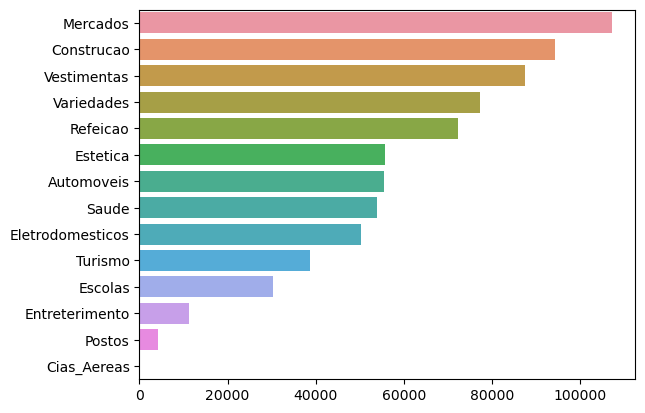

In [93]:
sns.barplot(data=df_C, x=df_C.st_ramo_x.value_counts().tolist(), y=df_C.st_ramo_x.value_counts().index)
plt.show()

### -Análise Faixa de TPV

In [94]:
df_C['Faixa_de_TPV'] = df_C.vl_potencial_faturamento_anual.apply(faixa_fat)

print(df_C.groupby(['Faixa_de_TPV']).Classe.count().sort_values(ascending=False))

Faixa_de_TPV
125k a 200k    168357
75k a 125k     151969
200k a 400k    133376
400k a 1M      130781
<40k            90530
40k a 75k       36316
1M a 10M        26522
10M a 40M         694
>40M               20
Name: Classe, dtype: int64


C:\Users\te-te\AppData\Local\Temp\ipykernel_61292\1112708184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Faixa_de_TPV'] = df_C.vl_potencial_faturamento_anual.apply(faixa_fat)


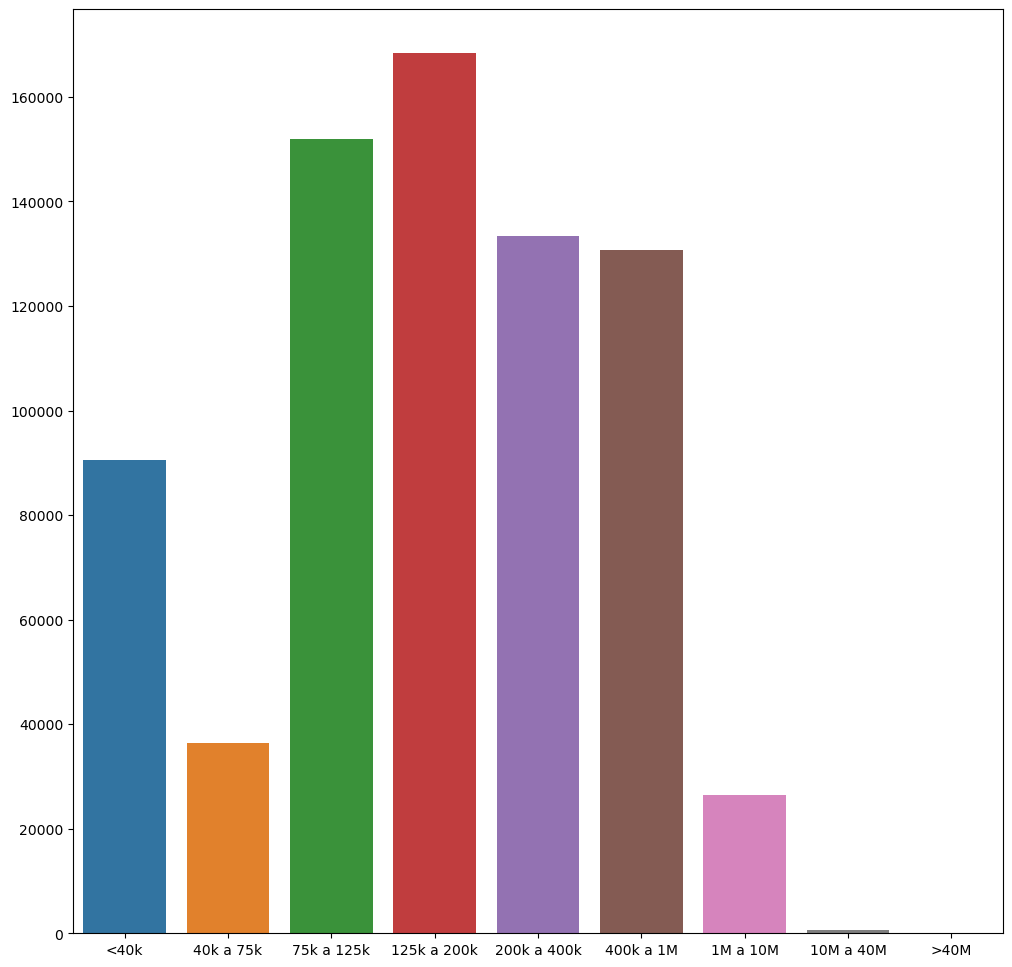

In [95]:
sns.barplot(data=df_C, y=df_C.Faixa_de_TPV.value_counts().tolist(), x=df_C.Faixa_de_TPV.value_counts().index, order = ['<40k', '40k a 75k', '75k a 125k', '125k a 200k', '200k a 400k', '400k a 1M', '1M a 10M', '10M a 40M', '>40M']).figure.set_size_inches(12,12)
plt.show()

### -Ramo x Faixa de TPV

In [96]:
print(df_C.groupby(['st_ramo_x']).vl_potencial_faturamento_anual.sum().sort_values(ascending=False))

st_ramo_x
Mercados            35338801399
Construcao          28276126000
Saude               26980027219
Variedades          21703725030
Vestimentas         20535746711
Automoveis          20422721822
Refeicao            17109176467
Turismo             13822669771
Eletrodomesticos    13723192372
Estetica            10184013402
Escolas              9538269791
Postos               4345529738
Entreterimento       4152738072
Cias_Aereas           491177498
Name: vl_potencial_faturamento_anual, dtype: int64


# Análise geral dos hubs









In [97]:
print(df)

         cd_cnpj_anonimizado   st_ramo_x Classe  \
0                   13827564  Construcao      A   
1                    9678391  Variedades      A   
2                    9678386  Variedades      A   
3                    9678389  Variedades      A   
4                      28847  Construcao      A   
...                      ...         ...    ...   
2338560              7985156     Escolas      C   
2338561              4780782       Saude      C   
2338562              3283714    Estetica      C   
2338563             11111880    Mercados      C   
2338564              9343436    Mercados      C   

         vl_potencial_faturamento_anual           LTV  
0                             120491780  1.603459e+06  
1                              56611425  6.222138e+05  
2                              56611425  6.222138e+05  
3                              56611425  6.222138e+05  
4                              43133026  5.739981e+05  
...                                 ...           .

### -Análise Ramos

In [98]:
print(df.groupby(['st_ramo_x']).Classe.count().sort_values(ascending=False))

st_ramo_x
Mercados            320011
Construcao          313189
Vestimentas         278383
Refeicao            247061
Variedades          240184
Automoveis          177463
Saude               177200
Estetica            158076
Eletrodomesticos    155079
Turismo             123940
Escolas              95486
Entreterimento       37818
Postos               14470
Cias_Aereas            205
Name: Classe, dtype: int64


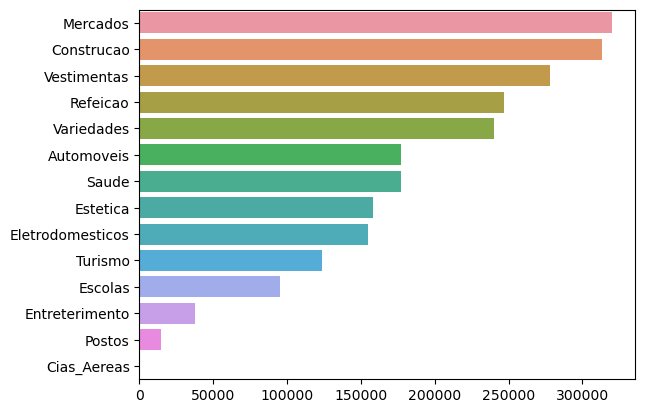

In [99]:
sns.barplot(data=df, x=df.st_ramo_x.value_counts().tolist(), y=df.st_ramo_x.value_counts().index)
plt.show()

### -Análise Faixa de TPV





In [100]:
df['Faixa_de_TPV'] = df.vl_potencial_faturamento_anual.apply(faixa_fat)

print(df.groupby(['Faixa_de_TPV']).Classe.count().sort_values(ascending=False))

Faixa_de_TPV
400k a 1M      530246
125k a 200k    511166
200k a 400k    491560
75k a 125k     371955
<40k           218412
1M a 10M       108360
40k a 75k      102786
10M a 40M        3988
>40M               92
Name: Classe, dtype: int64


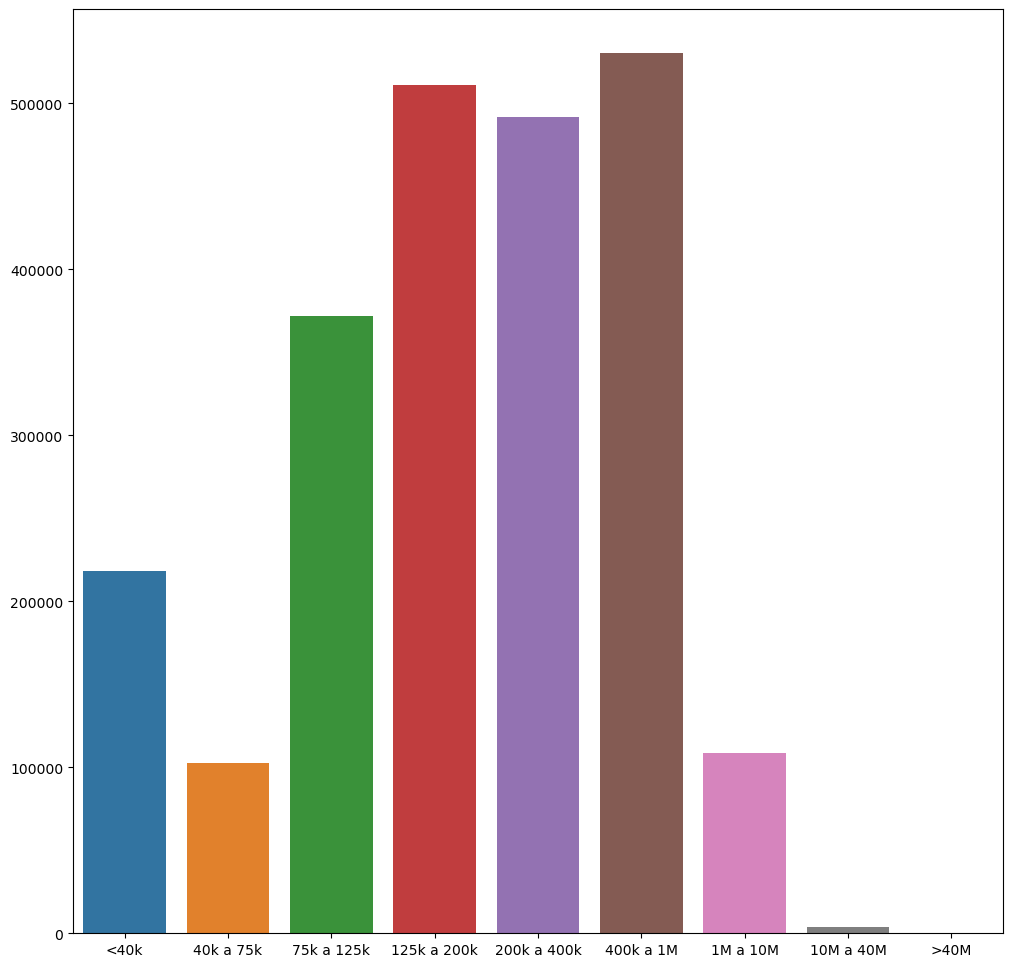

In [101]:
sns.barplot(data=df, y=df.Faixa_de_TPV.value_counts().tolist(), x=df.Faixa_de_TPV.value_counts().index, order = ['<40k', '40k a 75k', '75k a 125k', '125k a 200k', '200k a 400k', '400k a 1M', '1M a 10M', '10M a 40M', '>40M']).figure.set_size_inches(12,12)
plt.show()

### -Ramo x Faixa de TPV



In [102]:
print(df.groupby(['st_ramo_x']).vl_potencial_faturamento_anual.sum().sort_values(ascending=False))

st_ramo_x
Mercados            138191703586
Construcao          113941980769
Saude               106776186122
Variedades           82642660613
Vestimentas          80926697259
Automoveis           79797465128
Refeicao             72741952595
Turismo              55266175903
Eletrodomesticos     54920315894
Escolas              37674982299
Estetica             32033040609
Entreterimento       17387342820
Postos               16633506498
Cias_Aereas           1458868508
Name: vl_potencial_faturamento_anual, dtype: int64


## -Resumo Análise Descritiva

In [103]:
print('Ramos alocados com maior frequência: \n\n1) Mercados -> 303202 \n2) Construcao -> 291810 \n3) Vestimentas -> 261182')


Ramos alocados com maior frequência: 

1) Mercados -> 303202 
2) Construcao -> 291810 
3) Vestimentas -> 261182


In [104]:
print('Maiores frequências de faixas de TPV:\n\n400k a 1M -> 504586\n125k a 200k -> 482337\n200k a 400k -> 466499')


Maiores frequências de faixas de TPV:

400k a 1M -> 504586
125k a 200k -> 482337
200k a 400k -> 466499


In [105]:
print("Maiores faturamentos anuais por Ramo: \n\n1) Mercados -> 132181534949\n2) Construcao -> 107664094142\n3) Saude -> 102222022259")


Maiores faturamentos anuais por Ramo: 

1) Mercados -> 132181534949
2) Construcao -> 107664094142
3) Saude -> 102222022259


In [106]:
print('Porcentagem em relação ao LTV total do Brasil de cada hub:\n')
print(f"Hub do tipo A: {round((df[df['Classe'] == 'A'].LTV.sum() /LTV_total) * 100, 2)}%")
print(f"Hub do tipo B: {round((df[df['Classe'] == 'B'].LTV.sum() /LTV_total) * 100, 2)}%")
print(f"Hub do tipo C: {round((df[df['Classe'] == 'C'].LTV.sum() /LTV_total) * 100, 2)}%")

print('\nPorcentagem Total do ltv:\n')
print(f"{((round((df[df['Classe'] == 'A'].LTV.sum() /LTV_total) * 100, 2))+(round((df[df['Classe'] == 'B'].LTV.sum() /LTV_total) * 100, 2))+(round((df[df['Classe'] == 'C'].LTV.sum() /LTV_total) * 100, 2)))}%")

Porcentagem em relação ao LTV total do Brasil de cada hub:

Hub do tipo A: 28.14%
Hub do tipo B: 13.92%
Hub do tipo C: 16.68%

Porcentagem Total do ltv:

58.74%


In [107]:
print('Porcentagem de cadas hub em relação ao LTV maximo disponível no Brasil:\n')
print(f"Hub do tipo A: {round((df[df['Classe'] == 'A'].LTV.sum() /LTV_disponivel) * 100, 2)}%")
print(f"Hub do tipo B: {round((df[df['Classe'] == 'B'].LTV.sum() /LTV_disponivel) * 100, 2)}%")
print(f"Hub do tipo C: {round((df[df['Classe'] == 'C'].LTV.sum() /LTV_disponivel) * 100, 2)}%")

print('\nPorcentagem em relação ao ltv disponível:\n')
print(f"{((round((df[df['Classe'] == 'A'].LTV.sum() /LTV_disponivel) * 100, 2))+(round((df[df['Classe'] == 'B'].LTV.sum() /LTV_disponivel) * 100, 2))+(round((df[df['Classe'] == 'C'].LTV.sum() /LTV_disponivel) * 100, 2)))}%")

Porcentagem de cadas hub em relação ao LTV maximo disponível no Brasil:

Hub do tipo A: 34.84%
Hub do tipo B: 17.24%
Hub do tipo C: 20.65%

Porcentagem em relação ao ltv disponível:

72.72999999999999%


## Tranformação de lat e long para CEP












In [108]:
centroids = [[-16.58297619, -49.18121983, 'GO', 'B'],  [-8.19549872, -35.9720766,'PE' , 'B'], [-4.39093276, -39.0397883,'CE', 'C'], [-27.22200399, -49.71777823,'SC', 'A'],
        [-23.593, -48.020, 'SP', 'A'], [-22.914, -47.086, 'SP' , 'A'],  [-15.82795602, -47.97963765, 'DF', 'C'], [-20.11332405, -40.52739593, 'ES', 'C'] ]


In [109]:
hubs = pd.DataFrame(centroids, columns=['lat', 'lon', 'UF', 'classe'])
hubs['CEP'] = hubs.apply(lambda x: localizacao(str(x['lat']), str(x['lon'])), axis=1)

O CEP é: 74675-430
O CEP é: 55014-900
O CEP é: 62764-000
O CEP é: 89170-000
O CEP é: 18202-380
O CEP é: 13031-880
O CEP é: 71060-636
O CEP é: 29640-000


In [110]:
#Para esses centroides que não apresentam CEP, usa-se uma aproximação para o CEP mais próximo

centroid_manual = [[-29.50604948, -52.07953343, 'RS', 'B', '95930-000'], [-19.66359019, -44.56388694,'MG' ,'B', '35694-000'],
[-22.70880731, -43.14189407,'RJ', 'A',  '25903-587'], [-11.698, -38.909, 'BA', 'B', '48700-000'], [-25.080, -49.60, 'PR','A', '83560-000'],
[-21.821, -48.472, 'SP','C', '14813-000'],[-23.394, -51.257,'PR', 'C', '86072-000'] , [-7.05613487, -35.99635752, 'PB', 'C', '58150-000'], [-5.82623349, -36.01951999,'RN', 'C', '59540-000'],
[-3.40980075, -60.7401640, 'AM', 'C', '69400-000'], [-9.59723812, -36.14148849, 'AL','C', '57690-000'] , [-20.92488317, -54.44739041,'MS', 'C', '79065-000'] ]


In [111]:
hubs_manual = pd.DataFrame(centroid_manual , columns=['lat', 'lon', 'UF', 'classe', 'CEP'])
hubs = pd.concat([hubs, hubs_manual])

In [114]:
#Organizando o dataframe concatenado com os índices certos
hubs = hubs.reset_index()
hubs = hubs.sort_index()
hubs = hubs.drop(columns=['index'])
print(hubs)

          lat        lon  UF classe        CEP
0  -16.582976 -49.181220  GO      B  74675-430
1   -8.195499 -35.972077  PE      B  55014-900
2   -4.390933 -39.039788  CE      C  62764-000
3  -27.222004 -49.717778  SC      A  89170-000
4  -23.593000 -48.020000  SP      A  18202-380
5  -22.914000 -47.086000  SP      A  13031-880
6  -15.827956 -47.979638  DF      C  71060-636
7  -20.113324 -40.527396  ES      C  29640-000
8  -29.506049 -52.079533  RS      B  95930-000
9  -19.663590 -44.563887  MG      B  35694-000
10 -22.708807 -43.141894  RJ      A  25903-587
11 -11.698000 -38.909000  BA      B  48700-000
12 -25.080000 -49.600000  PR      A  83560-000
13 -21.821000 -48.472000  SP      C  14813-000
14 -23.394000 -51.257000  PR      C  86072-000
15  -7.056135 -35.996358  PB      C  58150-000
16  -5.826233 -36.019520  RN      C  59540-000
17  -3.409801 -60.740164  AM      C  69400-000
18  -9.597238 -36.141488  AL      C  57690-000
19 -20.924883 -54.447390  MS      C  79065-000
